---
title: Randomized SVD
description: Randomized singular value decomposition algorithm for efficient low-rank matrix approximation
keywords: [randomized SVD, singular value decomposition, low-rank approximation, matrix factorization, dimensionality reduction, random projection]
numbering:
  equation:
    enumerator: 5.%s
    continue: true
  proof:theorem:
    enumerator: 5.%s
    continue: true
  proof:algorithm:
    enumerator: 5.%s
    continue: true
  proof:definition:
    enumerator: 5.%s
    continue: true
  proof:proposition:
    enumerator: 5.%s
    continue: true
---

The Randomized SVD is perhaps the most widely known RandNLA algorithm.

:::{prf:algorithm} Randomized SVD
:label: alg-randomized-svd

**Input:** Matrix $A \in \R^{m \times n}$, target rank $k$, block-size $b\geq k$

1. Sample a random sketching matrix $\vec{\Omega}\sim\Call{Sketch}(n,b)$
1. Compute $\vec{Y} = \vec{A} \vec{\Omega}$
1. Compute QR factorization $\vec{Q}\vec{R} = \Call{qr}(\vec{Y})$
1. Compute $\vec{X} = \vec{A}^\T \vec{Q}$

**Output:** $\vec{Q}\vec{X}^\T$
:::

Note that the output can be easily factored into an "SVD-like" form $\vec{U} \vec{\Sigma} \vec{V}^\T$ by computing the SVD $\vec{U}'\vec{\Sigma}\vec{V} = \Call{svd}(\vec{X}^\T)$ and then setting $\vec{U} = \vec{Q}\vec{U}'$.

The approximation is not necessarily of rank-$k$. In most cases this is not an issue, but if a rank-$k$ approximation is required, one can simply truncate the approximate SVD to the first $k$ singular values; i.e. output $\vec{Q} \llbracket \vec{X}^\T \rrbracket_k$.

In [2]:
def randomized_SVD(A,k,b,rank_exactly_k=False):

    n,d = A.shape
    Ω = np.random.randn(d,b)
    Y = A@Ω
    Q,_ = np.linalg.qr(Y,mode='reduced')
    X = A.T@Q
    Up,s,Vt = np.linalg.svd(X.T,full_matrices=False)

    if rank_exactly_k:
        return Q@Up[:,:k],s[:k],Vt[:k]
    else:
        return Q@Up,s,Vt

## Numerical Example

Let's load an image as a numpy array. 
Here the image is of dimension 1333 by 2000.

In [46]:
import numpy as np
import scipy as sp
import time
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from randnla import *

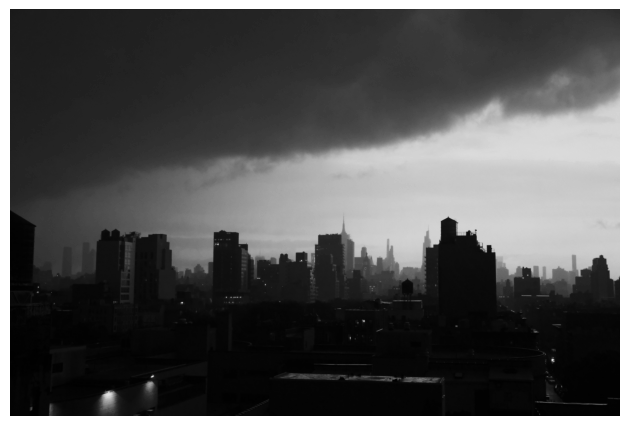

In [57]:
raw_image = plt.imread('nyc.jpg')
A = np.mean(raw_image,axis=-1) # get greyscale image
n,d = A.shape
plt.imshow(A,cmap='gray')
plt.axis('off')
plt.tight_layout()

### Compression via SVD

We can use the SVD to compress the image. 
When $k\approx 100$, we see that the resulting image is essentially indistinguishable from the original image.
However, by storing the compressed image in factored form, we require just $(n+d)k = 3.3\times 10^{5}$ parameters, which is roughly $12\%$ of the $nd = 2.6\times 10^6$ parameters required to store the original image!


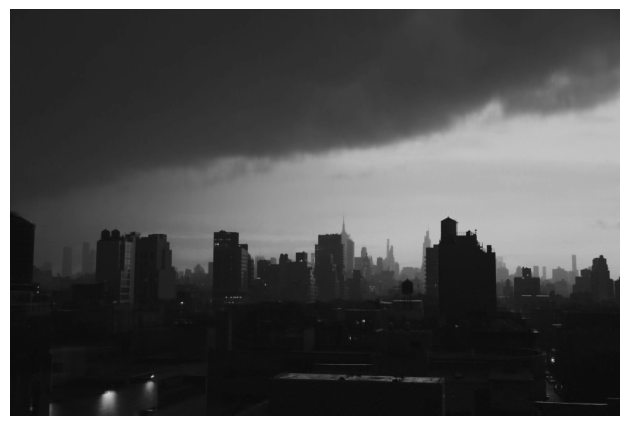

In [58]:
start = time.time()
U,s,Vt = np.linalg.svd(A,full_matrices=False)
end = time.time()

SVD_time = end-start

k = 100 # target rank

plt.imshow(U[:,:k]@np.diag(s[:k])@Vt[:k],cmap='gray')
plt.axis('off')
plt.tight_layout()

### Randomized SVD

Now let's consider the Randomized SVD. We'll use a block size $b=2k$, and truncate back to rank-$k$. 
Similar to the exact SVD, the rank-100 approximation produces by the Randomized SVD looks the same as the original image. 

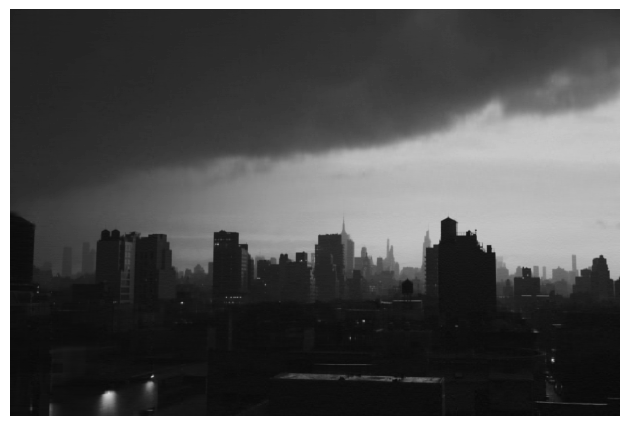

In [41]:
start = time.time()
U_rsvd,s_rsvd,Vt_rsvd = randomized_SVD(A,k,2*k,rank_exactly_k=True)
end = time.time()

RSVD_time = end-start


plt.imshow(U_rsvd@np.diag(s_rsvd)@Vt_rsvd,cmap='gray')
plt.axis('off')
plt.tight_layout()

### Runtime comparison

The upshot is that the Randomized SVD is way faster!! 
In this case roughly 20 times faster.

In [67]:
timing = [{
    'method':'SVD',
    'time (s)': SVD_time,
    'speedup': 1
},
{
    'method':'Randomized SVD',
    'time (s)': RSVD_time,
    'speedup': SVD_time/RSVD_time
}]

pd.DataFrame(timing).reindex(columns=['method','time (s)','speedup']).style.format({
    'time (s)': '{:.4f}',
    'speedup': '{:.1f}x',
})

,method,time (s),speedup
0,SVD,2.7719,1.0x
1,Randomized SVD,0.1523,18.2x


## Theoretical bounds


A prototypical bound for the Randomized SVD is the following:
:::{prf:theorem}
:label: thm-rsvd-frob
Suppose we use a Gaussian sketch. 
For any $b\geq k+2$, 
\begin{equation*}
\EE\left[ \| \vec{A} - \vec{U}\vec{\Sigma}\vec{V}^\T \|_\F^2 \right] \leq \left( 1 + \frac{k}{b-k-1} \right) \| \vec{A} - \llbracket \vec{A} \rrbracket_k \|_\F^2 .
\end{equation*}
:::
Bounds for the spectral norm are also available.

Full analyses can be found in {cite:p}`halko_martinsson_tropp_11,tropp_webber_23`, but getting some intuition is pretty simple!
Write the SVD of $\vec{A}$ as
\begin{equation}
\vec{A} 
= 
\begin{bmatrix}\vec{U}_1 & \vec{U}_2 \end{bmatrix} \begin{bmatrix} \vec{\Sigma}_1 \\ & \vec{\Sigma}_2 \end{bmatrix} 
\begin{bmatrix} \vec{V}_1^\T \\ \vec{V}_2^\T \end{bmatrix},
\end{equation}
where $\vec{U}_1$, $\vec{\Sigma}_1$ and $\vec{V}_1$ correspond to the top-$k$ singular vectors of $\vec{A}$; i.e. $\llbracket \vec{A} \rrbracket_k = \vec{U}_1 \vec{\Sigma}_1 \vec{V}_1^\T$.

Observe that
```{math}
\vec{Y} = \vec{A}\vec{\Omega} = \vec{U}_1\vec{\Sigma}_1\vec{V}_1^\T \vec{\Omega} + \vec{U}_1\vec{\Sigma}_1\vec{V}_1^\T \vec{\Omega}.
```
In the case that $\vec{\Sigma}_2 = \vec{0}$, then we will obtain $\vec{Q}$ so that $\range(\vec{Q}) = \range(\vec{U}_1)$.
In this case, $\vec{Q}\vec{Q}^\T$ would be the orthogonal projector onto the top left singular vectors of $\vec{A}$, and we would recover the best rank-$b$ approximation.
However, when $\vec{\Sigma}_2$ is nonzero, then the $\vec{Y}$ we get is perturbed.
However, for matrices with fast singular-value decay, $\vec{\Sigma}_2$ will be small, and the impact won't be so big.
Similarly, by increasing $b$, we can make $\vec{\Sigma}_2$ smaller.


